In [122]:
# I dont know if this is something typically done, I assume so though
# in this file I will experiment with how I can use ice mask to predict ice velocity
# since the ice mask prediction is quite good, I thought I could predict ice mask, then add that predicted
# column back in as a feature to be used in the ice velocity prediction. Since velocity is not being used
# as a predictor of ice mask, i believe there should be no data leak from this. 

import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import math
from sklearn.metrics import mean_squared_error


EF = pd.read_csv('../data/AIS_data/EF_full_df.csv')

velocity = EF[['ice_velocity']]
thickness = EF[['ice_thickness']]

#shifting the columns so the target is the one furthest to the right -> needed for scaling to avoid scaling ice mask
EF = EF[['x-axis', 'y-axis', 'precipitation', 'precip_roll', 'air_temp', 'air_roll', 'ocean_temp',
         'ocean_roll', 'temp_diff', 'dist', 'ice_velocity', 'ice_thickness','ice_mask']]

#method to normalise the data -> scale each column between 0 and 1 
def scale (df):
    """uses the formula scaled val = (val-column minimum)/(column maximum - column minimum)"""
    scaled_df = df.copy()
    # for column in df.columns[:-1]  -> use this line instead for not having a scaled target 
    for column in scaled_df.columns[:-1]:
        min_value = scaled_df[column].min()
        max_value = scaled_df[column].max()
        scaled_df[column] = (scaled_df[column] - min_value) / (max_value - min_value)
            
    return scaled_df

def scale_entire_df (df):
    """uses the formula scaled val = (val-column minimum)/(column maximum - column minimum)"""
    scaled_df = df.copy()
    # for column in df.columns[:-1]  -> use this line instead for not having a scaled target 
    for column in scaled_df.columns:
        min_value = scaled_df[column].min()
        max_value = scaled_df[column].max()
        scaled_df[column] = (scaled_df[column] - min_value) / (max_value - min_value)
            
    return scaled_df

def unscale_rmse(scaled_rmse, target_name, original_df):
    target_min = original_df[target_name].min()
    target_max = original_df[target_name].max()

    return scaled_rmse * (target_max - target_min)



In [123]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np

def doPolySVC(preprocessed_df, seed, n_runs):
    overall_accuracies = []
    training_accuracies = []
    category_accuracies = {'grounded_ice': [], 'floating_ice': [], 'open_ocean': []}
    training_category_accuracies = {'grounded_ice': [], 'floating_ice': [], 'open_ocean': []}

    for i in range(n_runs):
        randomState = i * seed
        X = preprocessed_df.iloc[:, :-1]
        y = preprocessed_df.iloc[:, -1]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randomState)
        
        #then remove the ice velocity from both xy train and test, but keep aside 
        
        model = SVC(kernel='poly', random_state=randomState, class_weight = 'balanced')
        model.fit(X_train, y_train)

        # Test data evaluation
        y_predicted = model.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_predicted)
        overall_accuracies.append(test_accuracy)
        
        test_cm = confusion_matrix(y_test, y_predicted, labels=[2.0, 3.0, 4.0])
        category_accuracies['grounded_ice'].append(test_cm[0, 0] / test_cm[0, :].sum() if test_cm[0, :].sum() > 0 else 0)
        category_accuracies['floating_ice'].append(test_cm[1, 1] / test_cm[1, :].sum() if test_cm[1, :].sum() > 0 else 0)
        category_accuracies['open_ocean'].append(test_cm[2, 2] / test_cm[2, :].sum() if test_cm[2, :].sum() > 0 else 0)

        # Training data evaluation
        y_train_predicted = model.predict(X_train)
        train_accuracy = accuracy_score(y_train, y_train_predicted)
        training_accuracies.append(train_accuracy)

        train_cm = confusion_matrix(y_train, y_train_predicted, labels=[2.0, 3.0, 4.0])
        training_category_accuracies['grounded_ice'].append(train_cm[0, 0] / train_cm[0, :].sum() if train_cm[0, :].sum() > 0 else 0)
        training_category_accuracies['floating_ice'].append(train_cm[1, 1] / train_cm[1, :].sum() if train_cm[1, :].sum() > 0 else 0)
        training_category_accuracies['open_ocean'].append(train_cm[2, 2] / train_cm[2, :].sum() if train_cm[2, :].sum() > 0 else 0)

    # Calculate averages and standard deviations
    average_accuracy = np.mean(overall_accuracies)
    std_accuracy = np.std(overall_accuracies)
    average_training_accuracy = np.mean(training_accuracies)
    std_training_accuracy = np.std(training_accuracies)

    average_category_accuracies = {k: np.mean(v) for k, v in category_accuracies.items()}
    std_category_accuracies = {k: np.std(v) for k, v in category_accuracies.items()}
    average_training_category_accuracies = {k: np.mean(v) for k, v in training_category_accuracies.items()}
    std_training_category_accuracies = {k: np.std(v) for k, v in training_category_accuracies.items()}

    # Print average and standard deviation of accuracies
    print(f"Average Training Accuracy: {average_training_accuracy:.3f}, Std: {std_training_accuracy:.3f}")
    print("Training Category Metrics:")
    for category in training_category_accuracies:
        print(f"  {category}: Avg: {average_training_category_accuracies[category]:.3f}, Std: {std_training_category_accuracies[category]:.3f}") 

    print(f"\nAverage Test Accuracy: {average_accuracy:.3f}, Std: {std_accuracy:.3f}")
    print("Test Category Metrics:")
    for category in category_accuracies:
        print(f"  {category}: Avg: {average_category_accuracies[category]:.3f}, Std: {std_category_accuracies[category]:.3f}")
    


In [142]:
# NOTE NEED TO DO STRATIFIED SPLITTING SINCE THE CLASS IS SO IMBALANCED 
def predict_ice_mask(preprocessed_df, randomState): 
        X = preprocessed_df.iloc[:, :-1]
        y = preprocessed_df.iloc[:, -1]
        
        #split into training and test 
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randomState, stratify = y)

        #then remove the ice velocity from both xy train and test, but keep aside 
        X_train_velocity = X_train['ice_velocity']
        X_train.drop(columns = ['ice_velocity'], inplace = True)
        X_test_velocity = X_test['ice_velocity']
        X_test.drop(columns = ['ice_velocity'], inplace = True)
        
        model = SVC(kernel='poly', random_state=randomState, class_weight = 'balanced')
        model.fit(X_train, y_train)

        # Training data evaluation
        y_train_predicted = model.predict(X_train)
        
        # Test data evaluation
        y_test_predicted = model.predict(X_test)
        
        #adding the data back together
        X_train['predicted_ice_mask'] = y_train_predicted
        X_train['ice_velocity'] = X_train_velocity
        X_test['predicted_ice_mask'] = y_test_predicted
        X_test['ice_velocity'] = X_test_velocity
        combined_df = pd.concat([X_train, X_test], ignore_index=True)
#         combined_df = combined_df[combined_df['predicted_ice_mask']<4]
#         combined_df = combined_df[combined_df['predicted_ice_mask']>2]

        return combined_df
    

seed = 101
preprocessed_df = EF.drop(columns = ['ice_thickness'], inplace = False)
preprocessed_df.fillna(value = -1, inplace = True)
preprocessed_df = preprocessed_df[preprocessed_df['ice_mask']>0]
preprocessed_df.head()
scaled_preprocessed_df = scale(preprocessed_df)
combined_df = predict_ice_mask(scaled_preprocessed_df, seed)
combined_df.head(20)

,x-axis,y-axis,precipitation,precip_roll,air_temp,air_roll,ocean_temp,ocean_roll,temp_diff,dist,predicted_ice_mask,ice_velocity
0,0.72,0.80,0.354136,0.303066,0.684237,0.684122,0.118837,0.188718,0.266558,0.681034,3,0.000000
1,0.70,0.32,0.024210,0.011864,0.152715,0.135411,0.101694,0.102993,0.829020,0.492572,2,0.001644
2,0.82,0.06,0.430673,0.695149,0.964158,0.967792,0.658699,0.647973,0.025430,0.995970,4,0.000000
3,0.66,0.96,0.244621,0.381899,0.850163,0.850256,0.363903,0.365954,0.115850,0.891575,4,0.000000
4,0.42,0.08,0.343400,0.541866,0.866092,0.865937,0.272373,0.274761,0.089442,0.782688,4,0.000000
5,0.44,0.00,0.373563,0.591767,0.875000,0.876637,0.269224,0.271157,0.079659,0.921882,4,0.000000
6,0.54,0.24,0.139407,0.203432,0.728970,0.732095,0.125867,0.107058,0.219802,0.481564,4,0.000000
7,0.34,0.16,0.316349,0.496799,0.844731,0.845669,0.303179,0.308168,0.115315,0.687888,4,0.000000
8,0.64,0.86,0.189269,0.265327,0.820755,0.801806,0.211675,0.250298,0.131271,0.707107,4,0.000000
9,0.28,0.60,0.081967,0.122548,0.512039,0.509563,0.009492,0.005328,0.438009,0.442392,3,0.179084


In [172]:
#+++++++++++++++++++++++++++++++++++++++++++++ RF REGRESSION +++++++++++++++++++++++++++++++++++++++++++
def doRandomForest_with_IM(preprocessed_df, seed, n_runs, target_name, original_df):
    train_scores = []
    test_scores = []
    train_RMSEs = []
    test_RMSEs = []
    importances = []

    for i in range(n_runs):
        randomState = seed*i
        df = predict_ice_mask(preprocessed_df, randomState)
        
        #deleting engineered features as they showed to be worse for predicting IV than without in previous runs 
        #df.drop(columns = ['precip_roll', 'air_roll', 'ocean_roll', 'temp_diff', 'dist'], inplace = True)

        X = df.iloc[:, :-1]
        y = df.iloc[:, -1]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                            random_state=randomState, 
                                                            stratify = X['predicted_ice_mask'])

        model = RandomForestRegressor(random_state=randomState)
        model.fit(X_train, y_train)
        
        # Store metrics for training set
        train_scores.append(model.score(X_train, y_train))
        y_train_predicted = model.predict(X_train)
        train_scaled_rmse = math.sqrt(mean_squared_error(y_train, y_train_predicted))
        train_rmse = unscale_rmse(train_scaled_rmse, target_name, original_df)
        train_RMSEs.append(train_rmse)

        # Store metrics for test set
#         print("X TEST")
#         print(X_test)
#         print ("Y TEST")
#         print(y_test)
        test_scores.append(model.score(X_test, y_test))
        importances.append(model.feature_importances_)
        y_test_predicted = model.predict(X_test)
        test_scaled_rmse = math.sqrt(mean_squared_error(y_test, y_test_predicted))
        test_rmse = unscale_rmse(test_scaled_rmse, target_name, original_df)
        test_RMSEs.append(test_rmse)

    # Calculate the average and standard deviation for each metric
    avg_train_score, std_train_score = np.mean(train_scores), np.std(train_scores)
    avg_test_score, std_test_score = np.mean(test_scores), np.std(test_scores)
    avg_train_rmse, std_train_rmse = np.mean(train_RMSEs), np.std(train_RMSEs)
    avg_test_rmse, std_test_rmse = np.mean(test_RMSEs), np.std(test_RMSEs)
    avg_importances, std_importances = np.mean(importances, axis=0), np.std(importances, axis=0)

    # Output the results
    print(f"Training Average Score: {avg_train_score:.4f}, Std Dev: {std_train_score:.4f}")
    print(f"Training Average RMSE: {avg_train_rmse:.2f}, Std Dev: {std_train_rmse:.2f}")
    print("\n")
    print(f"Test Average Score: {avg_test_score:.4f}, Std Dev: {std_test_score:.4f}")
    print(f"Test Average RMSE: {avg_test_rmse:.2f}, Std Dev: {std_test_rmse:.2f}")
    print("\n")
    print("Average Importances:", avg_importances)
    print("Importances Std Dev:", std_importances)
    print(f"\n\n Train-Test (Difference): {avg_train_score - avg_test_score :.4f}")


    return avg_importances, std_importances

seed = 101
preprocessed_df = EF.drop(columns = ['ice_thickness'], inplace = False)
preprocessed_df['ice_velocity'].fillna(value = -1, inplace = True)
preprocessed_df.head()
scaled_preprocessed_df = scale(preprocessed_df)
scaled_preprocessed_df.head()
IV_importances, IV_std_importances = doRandomForest_with_IM(scaled_preprocessed_df, seed, 
                                                    30, 'ice_velocity', preprocessed_df)


# I spent ages checking that the rmse or score was not calculated wrong, because these numbers looked so wrong
#in comparison to the numbers I had for IV previously. I realise now that the score (or r^2) is a measure of 
#how much of the variation in the data is explained by the model. The reason the score is so poor, but the rmse
#is actually better than previously is that these results use the data points with the ocean in it 
#these are represented with a -1. 

Training Average Score: 0.8614, Std Dev: 0.0107
Training Average RMSE: 72.35, Std Dev: 7.11


Test Average Score: 0.0101, Std Dev: 0.2013
Test Average RMSE: 207.00, Std Dev: 34.27


Average Importances: [0.05409063 0.06009094 0.25402531 0.10427511 0.0788071  0.09928606
 0.07552325 0.10132332 0.08884646 0.05858694 0.02514489]
Importances Std Dev: [0.01245571 0.01176753 0.05163945 0.02433841 0.01905602 0.03574722
 0.02244705 0.02386962 0.02682363 0.01099262 0.00790863]


 Train-Test (Difference): 0.8514


In [146]:
#+++++++++++++++++++++++++++++++++++++++++++++ RF REGRESSION +++++++++++++++++++++++++++++++++++++++++++
def doRandomForest(preprocessed_df, seed, n_runs, target_name, original_df):
    train_scores = []
    test_scores = []
    train_RMSEs = []
    test_RMSEs = []
    importances = []

    for i in range(n_runs):
        randomState = seed*i

        X = preprocessed_df.iloc[:, :-1]
        y = preprocessed_df.iloc[:, -1]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                            random_state=randomState)
        

        model = RandomForestRegressor(random_state=randomState)
        model.fit(X_train, y_train)
        
        # Store metrics for training set
        train_scores.append(model.score(X_train, y_train))
        y_train_predicted = model.predict(X_train)
        train_scaled_rmse = math.sqrt(mean_squared_error(y_train, y_train_predicted))
        train_rmse = unscale_rmse(train_scaled_rmse, target_name, original_df)
        train_RMSEs.append(train_rmse)

        # Store metrics for test set
#         print("X TEST")
#         print(X_test)
#         print ("Y TEST")
#         print(y_test)
        test_scores.append(model.score(X_test, y_test))
        importances.append(model.feature_importances_)
        y_test_predicted = model.predict(X_test)
        test_scaled_rmse = math.sqrt(mean_squared_error(y_test, y_test_predicted))
        test_rmse = unscale_rmse(test_scaled_rmse, target_name, original_df)
        test_RMSEs.append(test_rmse)

    # Calculate the average and standard deviation for each metric
    avg_train_score, std_train_score = np.mean(train_scores), np.std(train_scores)
    avg_test_score, std_test_score = np.mean(test_scores), np.std(test_scores)
    avg_train_rmse, std_train_rmse = np.mean(train_RMSEs), np.std(train_RMSEs)
    avg_test_rmse, std_test_rmse = np.mean(test_RMSEs), np.std(test_RMSEs)
    avg_importances, std_importances = np.mean(importances, axis=0), np.std(importances, axis=0)

    # Output the results
    print(f"Training Average Score: {avg_train_score:.4f}, Std Dev: {std_train_score:.4f}")
    print(f"Training Average RMSE: {avg_train_rmse:.2f}, Std Dev: {std_train_rmse:.2f}")
    print("\n")
    print(f"Test Average Score: {avg_test_score:.4f}, Std Dev: {std_test_score:.4f}")
    print(f"Test Average RMSE: {avg_test_rmse:.2f}, Std Dev: {std_test_rmse:.2f}")
    print("\n")
    print("Average Importances:", avg_importances)
    print("Importances Std Dev:", std_importances)
    print(f"\n\n Train-Test (Difference): {avg_train_score - avg_test_score :.4f}")


    return avg_importances, std_importances

seed = 101
preprocessed_df = EF.drop(columns = ['ice_thickness', 'ice_mask'], inplace = False)
preprocessed_df['ice_velocity'].fillna(value = -1, inplace = True)
preprocessed_df.head()
scaled_preprocessed_df = scale(preprocessed_df)
scaled_preprocessed_df.head()
IV_importances, IV_std_importances = doRandomForest(scaled_preprocessed_df, seed, 
                                                    30, 'ice_velocity', preprocessed_df)


Training Average Score: 0.8588, Std Dev: 0.0148
Training Average RMSE: 268266.11, Std Dev: 28286.49


Test Average Score: -0.1538, Std Dev: 0.5794
Test Average RMSE: 719326.56, Std Dev: 126994.44


Average Importances: [0.05217541 0.04816585 0.2464424  0.13132694 0.08136328 0.13278727
 0.07544858 0.09764958 0.07856701 0.0560737 ]
Importances Std Dev: [0.00976667 0.0152732  0.05540891 0.03467489 0.0172989  0.03178872
 0.0176762  0.0211172  0.01718129 0.01214683]


 Train-Test (Difference): 1.0126


In [162]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import math

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import math

def tune_model(preprocessed_df, seed, n_runs):
    best_params = []
    
    df = predict_ice_mask(preprocessed_df, seed)
    
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                        random_state=seed, stratify = X['predicted_ice_mask'])

    for i in range(n_runs):
        randomState = i * seed

        # Define the model -> the random state means different trees will be created each time
                        #  -> but in a controlled way so it is reproducible 
        rf = RandomForestRegressor(random_state=randomState)

        # Set up the grid of parameters to search
        param_grid = {
        'n_estimators': [100, 200, 300],  # Number of trees in the forest
        'max_features': [2, 3, 6, 9],  # Number of features to consider at every split
        'max_depth': [5, 10, 20, None],   # Maximum number of levels in tree
        'min_samples_split': [2, 5, 10, 15, 20],   # Minimum number of samples required to split a node
        'min_samples_leaf': [1, 2, 4, 6, 10],     # Minimum number of samples required at each leaf node
        'max_leaf_nodes':[20, 40, 60, 90]

        }

        # Set up the grid search
        grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)

        # Fit the grid search to the data
        grid_search.fit(X_train, y_train)

        # Store best parameters
        best_params.append(grid_search.cv_results_['params'][grid_search.best_index_])

    print("Best Parameters per Run:", best_params)

    return best_params, param_grid

In [163]:
seed = 101
n_runs = 30

preprocessed_df = EF.drop(columns = ['ice_thickness'], inplace = False)
preprocessed_df['ice_velocity'].fillna(value = -1, inplace = True)
preprocessed_df.head()
scaled_preprocessed_df = scale(preprocessed_df)
best_params, param_grid = tune_model(scaled_preprocessed_df, seed, n_runs)



#         'n_estimators': [100, 200, 300],  # Number of trees in the forest
#         'max_features': [2, 3, 6, 9],  # Number of features to consider at every split
#         'max_depth': [5, 10, 20, None],   # Maximum number of levels in tree
#         'min_samples_split': [2, 5, 10, 15, 20],   # Minimum number of samples required to split a node
#         'min_samples_leaf': [1, 2, 4, 6, 10],     # Minimum number of samples required at each leaf node
#         'max_leaf_nodes':[20, 40, 60, 90]

# started at 2.02pm 

Fitting 3 folds for each of 4800 candidates, totalling 14400 fits
Fitting 3 folds for each of 4800 candidates, totalling 14400 fits
Fitting 3 folds for each of 4800 candidates, totalling 14400 fits
Fitting 3 folds for each of 4800 candidates, totalling 14400 fits
Fitting 3 folds for each of 4800 candidates, totalling 14400 fits
Fitting 3 folds for each of 4800 candidates, totalling 14400 fits
Fitting 3 folds for each of 4800 candidates, totalling 14400 fits
Fitting 3 folds for each of 4800 candidates, totalling 14400 fits
Fitting 3 folds for each of 4800 candidates, totalling 14400 fits
Fitting 3 folds for each of 4800 candidates, totalling 14400 fits
Fitting 3 folds for each of 4800 candidates, totalling 14400 fits
Fitting 3 folds for each of 4800 candidates, totalling 14400 fits
Fitting 3 folds for each of 4800 candidates, totalling 14400 fits
Fitting 3 folds for each of 4800 candidates, totalling 14400 fits
Fitting 3 folds for each of 4800 candidates, totalling 14400 fits
Fitting 3 

param counts
n_estimators
100    16
200     5
300     9
Name: count, dtype: int64


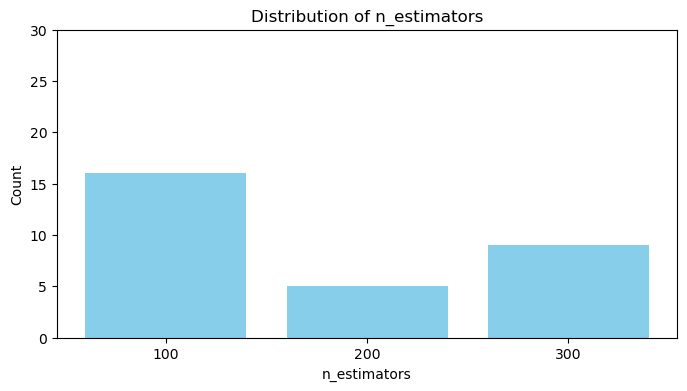

param counts
max_features
2    23
3     4
6     2
9     1
Name: count, dtype: int64


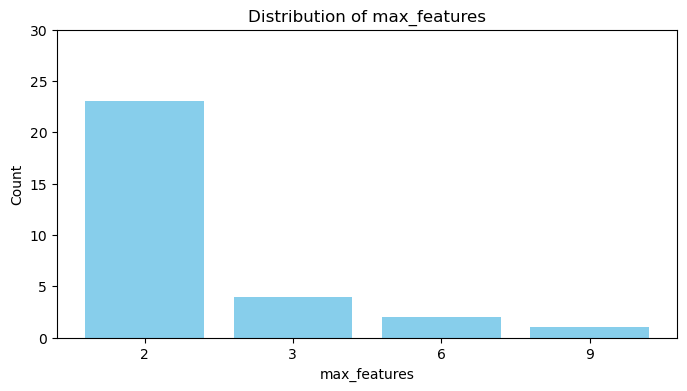

param counts
max_depth
5        4
10       6
20      20
None     0
Name: count, dtype: int64


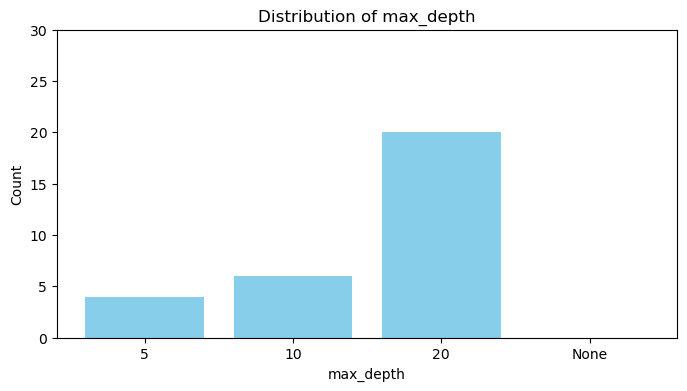

param counts
min_samples_split
2     25
5      0
10     0
15     1
20     4
Name: count, dtype: int64


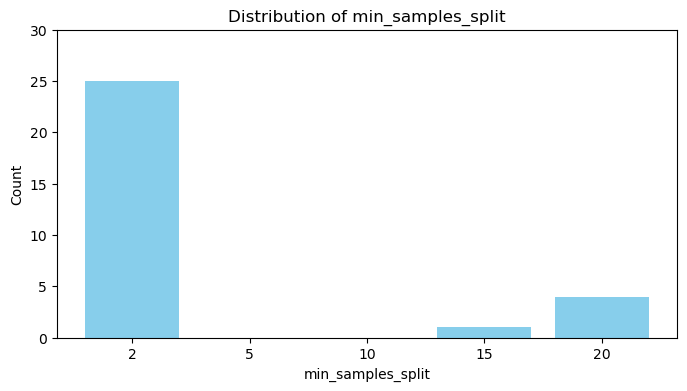

param counts
min_samples_leaf
1      2
2      0
4      1
6      4
10    23
Name: count, dtype: int64


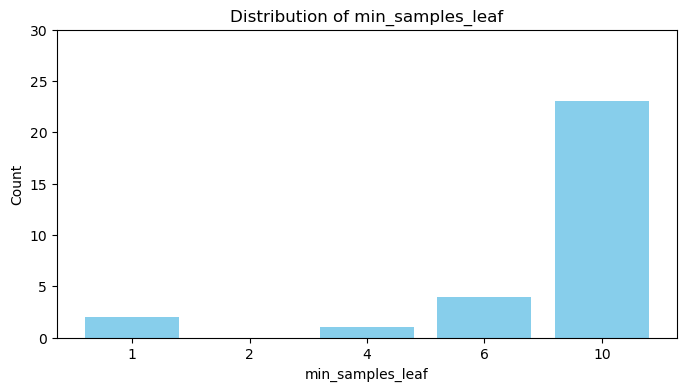

param counts
max_leaf_nodes
20     4
40    24
60     2
90     0
Name: count, dtype: int64


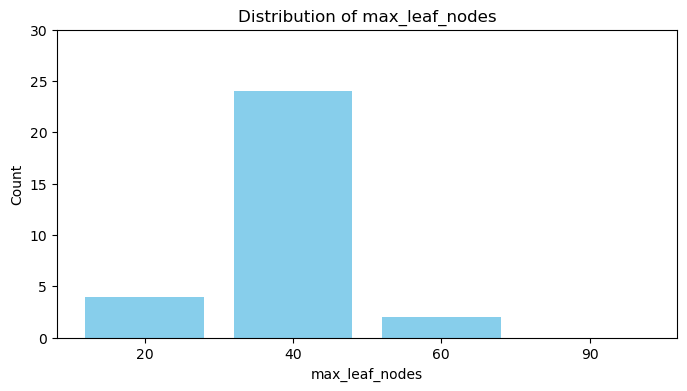

In [165]:
import matplotlib.pyplot as plt

def visualize_parameter_distribution_no_grid(param_dict, param_grid, n_runs):
    # Convert 'None' to string 'None' for 'max_depth'
    for d in param_dict:
        if 'max_depth' in d and d['max_depth'] is None:
            d['max_depth'] = 'None'
    
    # Convert the dictionary to a DataFrame for easier manipulation
    df = pd.DataFrame(param_dict)

    # Loop through each parameter in the grid and create separate bar charts
    for param, values in param_grid.items():
        
        if param == "max_depth":
            values = ['None' if v is None else v for v in values]
            
        
        # Count the occurrences of each parameter value in the dictionary
        param_counts = df[param].value_counts().reindex(values, fill_value=0)
        print("param counts")
        print(param_counts)
        # Plot the bar chart for the parameter
        plt.figure(figsize=(8, 4))
        plt.bar(param_counts.index.astype(str), param_counts.values, color='skyblue')
        plt.title(f'Distribution of {param}')
        plt.xlabel(param)
        plt.ylabel('Count')
        plt.ylim(0, n_runs)  # Set y-axis limit to n_runs
        plt.show()

# Call the function with the 'n_runs' parameter
n_runs=30
visualize_parameter_distribution_no_grid(best_params, param_grid, n_runs)


In [171]:
#+++++++++++++++++++++++++++++++++++++++++++++ RF REGRESSION +++++++++++++++++++++++++++++++++++++++++++
def doTunedRandomForest_With_Ice_Mask(preprocessed_df, seed, n_runs, target_name, original_df):
    train_scores = []
    test_scores = []
    train_RMSEs = []
    test_RMSEs = []
    importances = []

    for i in range(n_runs):
        randomState = seed*i
        
        df = predict_ice_mask(preprocessed_df, randomState)
        
        #deleting engineered features as they showed to be worse for predicting IV than without in previous runs 
        #df.drop(columns = ['precip_roll', 'air_roll', 'ocean_roll', 'temp_diff', 'dist'], inplace = True)
        
        
        X = df.iloc[:, :-1]
        y = df.iloc[:, -1]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                            random_state=randomState, 
                                                            stratify = X['predicted_ice_mask'])
        

        model = RandomForestRegressor(random_state=randomState, n_estimators = 100, max_features = 2,
                                     max_depth = 20, min_samples_split = 2, min_samples_leaf = 10,  
                                     max_leaf_nodes = 40)
        model.fit(X_train, y_train)
        
        # Store metrics for training set
        train_scores.append(model.score(X_train, y_train))
        y_train_predicted = model.predict(X_train)
        train_scaled_rmse = math.sqrt(mean_squared_error(y_train, y_train_predicted))
        train_rmse = unscale_rmse(train_scaled_rmse, target_name, original_df)
        train_RMSEs.append(train_rmse)

        # Store metrics for test set
#         print("X TEST")
#         print(X_test)
#         print ("Y TEST")
#         print(y_test)
        test_scores.append(model.score(X_test, y_test))
        importances.append(model.feature_importances_)
        y_test_predicted = model.predict(X_test)
        test_scaled_rmse = math.sqrt(mean_squared_error(y_test, y_test_predicted))
        test_rmse = unscale_rmse(test_scaled_rmse, target_name, original_df)
        test_RMSEs.append(test_rmse)

    # Calculate the average and standard deviation for each metric
    avg_train_score, std_train_score = np.mean(train_scores), np.std(train_scores)
    avg_test_score, std_test_score = np.mean(test_scores), np.std(test_scores)
    avg_train_rmse, std_train_rmse = np.mean(train_RMSEs), np.std(train_RMSEs)
    avg_test_rmse, std_test_rmse = np.mean(test_RMSEs), np.std(test_RMSEs)
    avg_importances, std_importances = np.mean(importances, axis=0), np.std(importances, axis=0)

    # Output the results
    print(f"Training Average Score: {avg_train_score:.4f}, Std Dev: {std_train_score:.4f}")
    print(f"Training Average RMSE: {avg_train_rmse:.2f}, Std Dev: {std_train_rmse:.2f}")
    print("\n")
    print(f"Test Average Score: {avg_test_score:.4f}, Std Dev: {std_test_score:.4f}")
    print(f"Test Average RMSE: {avg_test_rmse:.2f}, Std Dev: {std_test_rmse:.2f}")
    print("\n")
    print("Average Importances:", avg_importances)
    print("Importances Std Dev:", std_importances)
    print(f"\n\n Train-Test (Difference): {avg_train_score - avg_test_score :.4f}")


    return avg_importances, std_importances

seed = 101
preprocessed_df = EF.drop(columns = ['ice_thickness'], inplace = False)
preprocessed_df['ice_velocity'].fillna(value = -1, inplace = True)
preprocessed_df.head()
scaled_preprocessed_df = scale(preprocessed_df)
scaled_preprocessed_df.head()
IV_importances, IV_std_importances = doTunedRandomForest_With_Ice_Mask(scaled_preprocessed_df, seed, 
                                                    30, 'ice_velocity', preprocessed_df)



Training Average Score: 0.3050, Std Dev: 0.0179
Training Average RMSE: 162.33, Std Dev: 16.45


Test Average Score: 0.1427, Std Dev: 0.0382
Test Average RMSE: 195.51, Std Dev: 38.58


Average Importances: [0.05808456 0.0364453  0.17510114 0.10865512 0.09798569 0.09421513
 0.10384589 0.10375284 0.10015385 0.06977812 0.05198237]
Importances Std Dev: [0.01059634 0.00591617 0.03981239 0.01658087 0.01565924 0.01202467
 0.02717987 0.02898704 0.01395804 0.01310702 0.01053088]


 Train-Test (Difference): 0.1623


In [176]:
#+++++++++++++++++++++++++++++++++++++++++++++ RF REGRESSION +++++++++++++++++++++++++++++++++++++++++++
def doRandomForest_with_IM_IT(preprocessed_df, seed, n_runs, target_name, original_df):
    train_scores = []
    test_scores = []
    train_RMSEs = []
    test_RMSEs = []
    importances = []

    for i in range(n_runs):
        randomState = seed*i
        df = predict_ice_mask_IT(preprocessed_df, randomState)
        
        #deleting engineered features as they showed to be worse for predicting IV than without in previous runs 
        #df.drop(columns = ['precip_roll', 'air_roll', 'ocean_roll', 'temp_diff', 'dist'], inplace = True)

        X = df.iloc[:, :-1]
        y = df.iloc[:, -1]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                            random_state=randomState, 
                                                            stratify = X['predicted_ice_mask'])

        model = RandomForestRegressor(random_state=randomState)
        model.fit(X_train, y_train)
        
        # Store metrics for training set
        train_scores.append(model.score(X_train, y_train))
        y_train_predicted = model.predict(X_train)
        train_scaled_rmse = math.sqrt(mean_squared_error(y_train, y_train_predicted))
        train_rmse = unscale_rmse(train_scaled_rmse, target_name, original_df)
        train_RMSEs.append(train_rmse)

        # Store metrics for test set
#         print("X TEST")
#         print(X_test)
#         print ("Y TEST")
#         print(y_test)
        test_scores.append(model.score(X_test, y_test))
        importances.append(model.feature_importances_)
        y_test_predicted = model.predict(X_test)
        test_scaled_rmse = math.sqrt(mean_squared_error(y_test, y_test_predicted))
        test_rmse = unscale_rmse(test_scaled_rmse, target_name, original_df)
        test_RMSEs.append(test_rmse)

    # Calculate the average and standard deviation for each metric
    avg_train_score, std_train_score = np.mean(train_scores), np.std(train_scores)
    avg_test_score, std_test_score = np.mean(test_scores), np.std(test_scores)
    avg_train_rmse, std_train_rmse = np.mean(train_RMSEs), np.std(train_RMSEs)
    avg_test_rmse, std_test_rmse = np.mean(test_RMSEs), np.std(test_RMSEs)
    avg_importances, std_importances = np.mean(importances, axis=0), np.std(importances, axis=0)

    # Output the results
    print(f"Training Average Score: {avg_train_score:.4f}, Std Dev: {std_train_score:.4f}")
    print(f"Training Average RMSE: {avg_train_rmse:.2f}, Std Dev: {std_train_rmse:.2f}")
    print("\n")
    print(f"Test Average Score: {avg_test_score:.4f}, Std Dev: {std_test_score:.4f}")
    print(f"Test Average RMSE: {avg_test_rmse:.2f}, Std Dev: {std_test_rmse:.2f}")
    print("\n")
    print("Average Importances:", avg_importances)
    print("Importances Std Dev:", std_importances)
    print(f"\n\n Train-Test (Difference): {avg_train_score - avg_test_score :.4f}")


    return avg_importances, std_importances

seed = 101
preprocessed_df = EF.drop(columns = ['ice_velocity'], inplace = False)
preprocessed_df.head()
scaled_preprocessed_df = scale(preprocessed_df)
scaled_preprocessed_df.head()
IV_importances, IV_std_importances = doRandomForest_with_IM_IT(scaled_preprocessed_df, seed, 
                                                    30, 'ice_thickness', preprocessed_df)


Training Average Score: 0.9923, Std Dev: 0.0003
Training Average RMSE: 102.62, Std Dev: 2.52


Test Average Score: 0.9428, Std Dev: 0.0059
Test Average RMSE: 277.40, Std Dev: 13.04


Average Importances: [0.01681606 0.01847561 0.00822546 0.00794717 0.06767558 0.25899726
 0.01038293 0.00942075 0.34524174 0.01366833 0.24314911]
Importances Std Dev: [0.00228908 0.00137209 0.0007124  0.00084019 0.03343935 0.11093091
 0.00204471 0.0012102  0.10382713 0.0014597  0.15390692]


 Train-Test (Difference): 0.0494


In [177]:
# NOTE NEED TO DO STRATIFIED SPLITTING SINCE THE CLASS IS SO IMBALANCED 
def predict_ice_mask_IT(preprocessed_df, randomState): 
        X = preprocessed_df.iloc[:, :-1]
        y = preprocessed_df.iloc[:, -1]
        
        #split into training and test 
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randomState, stratify = y)

        #then remove the ice velocity from both xy train and test, but keep aside 
        X_train_velocity = X_train['ice_thickness']
        X_train.drop(columns = ['ice_thickness'], inplace = True)
        X_test_velocity = X_test['ice_thickness']
        X_test.drop(columns = ['ice_thickness'], inplace = True)
        
        model = SVC(kernel='poly', random_state=randomState, class_weight = 'balanced')
        model.fit(X_train, y_train)

        # Training data evaluation
        y_train_predicted = model.predict(X_train)
        
        # Test data evaluation
        y_test_predicted = model.predict(X_test)
        
        #adding the data back together
        X_train['predicted_ice_mask'] = y_train_predicted
        X_train['ice_thickness'] = X_train_velocity
        X_test['predicted_ice_mask'] = y_test_predicted
        X_test['ice_thickness'] = X_test_velocity
        combined_df = pd.concat([X_train, X_test], ignore_index=True)
#         combined_df = combined_df[combined_df['predicted_ice_mask']<4]
#         combined_df = combined_df[combined_df['predicted_ice_mask']>2]

        return combined_df
    

seed = 101
preprocessed_df = EF.drop(columns = ['ice_velocity'], inplace = False)
preprocessed_df.fillna(value = -1, inplace = True)
preprocessed_df = preprocessed_df[preprocessed_df['ice_mask']>0]
preprocessed_df.head()
scaled_preprocessed_df = scale(preprocessed_df)
combined_df = predict_ice_mask(scaled_preprocessed_df, seed)
combined_df.head(20)

,x-axis,y-axis,precipitation,precip_roll,air_temp,air_roll,ocean_temp,ocean_roll,temp_diff,dist,predicted_ice_mask,ice_thickness
0,0.72,0.80,0.354136,0.303066,0.684237,0.684122,0.118837,0.188718,0.266558,0.681034,3,0.000000
1,0.70,0.32,0.024210,0.011864,0.152715,0.135411,0.101694,0.102993,0.829020,0.492572,2,0.749499
2,0.82,0.06,0.430673,0.695149,0.964158,0.967792,0.658699,0.647973,0.025430,0.995970,4,0.000000
3,0.66,0.96,0.244621,0.381899,0.850163,0.850256,0.363903,0.365954,0.115850,0.891575,4,0.000000
4,0.42,0.08,0.343400,0.541866,0.866092,0.865937,0.272373,0.274761,0.089442,0.782688,4,0.000000
5,0.44,0.00,0.373563,0.591767,0.875000,0.876637,0.269224,0.271157,0.079659,0.921882,4,0.000000
6,0.54,0.24,0.139407,0.203432,0.728970,0.732095,0.125867,0.107058,0.219802,0.481564,4,0.000000
7,0.34,0.16,0.316349,0.496799,0.844731,0.845669,0.303179,0.308168,0.115315,0.687888,4,0.000000
8,0.64,0.86,0.189269,0.265327,0.820755,0.801806,0.211675,0.250298,0.131271,0.707107,4,0.000000
9,0.28,0.60,0.081967,0.122548,0.512039,0.509563,0.009492,0.005328,0.438009,0.442392,3,0.123382
